In [3]:
input_form = """

<table>

<td style="border-style: none;">

<div style="border: solid 2px #666; width: 143px; height: 144px;">

<canvas width="140" height="140"></canvas>

</div></td>

<td style="border-style: none;">

<button onclick="clear_value()">Clear</button>

</td>

</table>

"""



javascript = """

<script type="text/Javascript">

    var pixels = [];

    for (var i = 0; i < 28*28; i++) pixels[i] = 0

    var click = 0;



    var canvas = document.querySelector("canvas");

    canvas.addEventListener("mousemove", function(e){

        if (e.buttons == 1) {

            click = 1;

            canvas.getContext("2d").fillStyle = "rgb(0,0,0)";

            canvas.getContext("2d").fillRect(e.offsetX, e.offsetY, 8, 8);

            x = Math.floor(e.offsetY * 0.2)

            y = Math.floor(e.offsetX * 0.2) + 1

            for (var dy = 0; dy < 2; dy++){

                for (var dx = 0; dx < 2; dx++){

                    if ((x + dx < 28) && (y + dy < 28)){

                        pixels[(y+dy)+(x+dx)*28] = 1

                    }

                }

            }

        } else {

            if (click == 1) set_value()

            click = 0;

        }

    });

    

    function set_value(){

        var result = ""

        for (var i = 0; i < 28*28; i++) result += pixels[i] + ","

        var kernel = IPython.notebook.kernel;

        kernel.execute("image = [" + result + "]");

    }

    

    function clear_value(){

        canvas.getContext("2d").fillStyle = "rgb(255,255,255)";

        canvas.getContext("2d").fillRect(0, 0, 140, 140);

        for (var i = 0; i < 28*28; i++) pixels[i] = 0

    }

</script>

"""


In [5]:
from IPython.display import HTML

HTML(input_form + javascript)

In [12]:
#training

import tensorflow as tf

import numpy as np

import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data




tf.reset_default_graph() 



np.random.seed(20160704)

tf.set_random_seed(20160704)



# load data

mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)



# define first layer

num_filters1 = 32



x = tf.placeholder(tf.float32, [None, 784])

x_image = tf.reshape(x, [-1,28,28,1])



W_conv1 = tf.Variable(tf.truncated_normal([5,5,1,num_filters1],

                                          stddev=0.1))

h_conv1 = tf.nn.conv2d(x_image, W_conv1,

                       strides=[1,1,1,1], padding='SAME')



b_conv1 = tf.Variable(tf.constant(0.1, shape=[num_filters1]))

h_conv1_cutoff = tf.nn.relu(h_conv1 + b_conv1)



h_pool1 = tf.nn.max_pool(h_conv1_cutoff, ksize=[1,2,2,1],

                         strides=[1,2,2,1], padding='SAME')



# define second layer

num_filters2 = 64



W_conv2 = tf.Variable(

            tf.truncated_normal([5,5,num_filters1,num_filters2],

                                stddev=0.1))

h_conv2 = tf.nn.conv2d(h_pool1, W_conv2,

                       strides=[1,1,1,1], padding='SAME')



b_conv2 = tf.Variable(tf.constant(0.1, shape=[num_filters2]))

h_conv2_cutoff = tf.nn.relu(h_conv2 + b_conv2)



h_pool2 = tf.nn.max_pool(h_conv2_cutoff, ksize=[1,2,2,1],

                         strides=[1,2,2,1], padding='SAME')



# define fully connected layer

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*num_filters2])



num_units1 = 7*7*num_filters2

num_units2 = 1024



w2 = tf.Variable(tf.truncated_normal([num_units1, num_units2]))

b2 = tf.Variable(tf.constant(0.1, shape=[num_units2]))

hidden2 = tf.nn.relu(tf.matmul(h_pool2_flat, w2) + b2)



keep_prob = tf.placeholder(tf.float32)

hidden2_drop = tf.nn.dropout(hidden2, keep_prob)



w0 = tf.Variable(tf.zeros([num_units2, 10]))

b0 = tf.Variable(tf.zeros([10]))

k = tf.matmul(hidden2_drop, w0) + b0

p = tf.nn.softmax(k)



#define loss (cost) function

t = tf.placeholder(tf.float32, [None, 10])

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=k,labels=t)) 

train_step = tf.train.AdamOptimizer(0.0001).minimize(loss)

correct_prediction = tf.equal(tf.argmax(p, 1), tf.argmax(t, 1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))



# prepare session

sess = tf.InteractiveSession()

sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()



# start training

i = 0

for _ in range(1000):

    i += 1

    batch_xs, batch_ts = mnist.train.next_batch(50)

    sess.run(train_step,

             feed_dict={x:batch_xs, t:batch_ts, keep_prob:0.5})

    if i % 500 == 0:

        loss_vals, acc_vals = [], []

        for c in range(4):

            start = int(len(mnist.test.labels) / 4 * c)

            end = int(len(mnist.test.labels) / 4 * (c+1))

            loss_val, acc_val = sess.run([loss, accuracy],

                feed_dict={x:mnist.test.images[start:end],

                           t:mnist.test.labels[start:end],

                           keep_prob:1.0})

            loss_vals.append(loss_val)

            acc_vals.append(acc_val)

        loss_val = np.sum(loss_vals)

        acc_val = np.mean(acc_vals)

        print ('Step: %d, Loss: %f, Accuracy: %f'

               % (i, loss_val, acc_val))



saver.save(sess, './Network_Parameters/cnn_session')

#sess.close()

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Step: 500, Loss: 0.604932, Accuracy: 0.952500
Step: 1000, Loss: 0.377292, Accuracy: 0.971700


'./Network_Parameters/cnn_session'

In [5]:
#load

import tensorflow as tf

import numpy as np

import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data



#이미 그래프가 있을 경우 중복이 될 수 있기 때문에, 기존 그래프를 모두 리셋한다.

tf.reset_default_graph() 



num_filters1 = 32



x = tf.placeholder(tf.float32, [None, 784])

x_image = tf.reshape(x, [-1,28,28,1])



#  layer 1

W_conv1 = tf.Variable(tf.truncated_normal([5,5,1,num_filters1],

                                          stddev=0.1))

h_conv1 = tf.nn.conv2d(x_image, W_conv1,

                       strides=[1,1,1,1], padding='SAME')



b_conv1 = tf.Variable(tf.constant(0.1, shape=[num_filters1]))

h_conv1_cutoff = tf.nn.relu(h_conv1 + b_conv1)



h_pool1 =tf.nn.max_pool(h_conv1_cutoff, ksize=[1,2,2,1],

                        strides=[1,2,2,1], padding='SAME')



num_filters2 = 64



# layer 2

W_conv2 = tf.Variable(

            tf.truncated_normal([5,5,num_filters1,num_filters2],

                                stddev=0.1))

h_conv2 = tf.nn.conv2d(h_pool1, W_conv2,

                       strides=[1,1,1,1], padding='SAME')



b_conv2 = tf.Variable(tf.constant(0.1, shape=[num_filters2]))

h_conv2_cutoff = tf.nn.relu(h_conv2 + b_conv2)



h_pool2 =tf.nn.max_pool(h_conv2_cutoff, ksize=[1,2,2,1],

                        strides=[1,2,2,1], padding='SAME')



# fully connected layer

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*num_filters2])



num_units1 = 7*7*num_filters2

num_units2 = 1024



w2 = tf.Variable(tf.truncated_normal([num_units1, num_units2]))

b2 = tf.Variable(tf.constant(0.1, shape=[num_units2]))

hidden2 = tf.nn.relu(tf.matmul(h_pool2_flat, w2) + b2)



keep_prob = tf.placeholder(tf.float32)

hidden2_drop = tf.nn.dropout(hidden2, keep_prob)



w0 = tf.Variable(tf.zeros([num_units2, 10]))

b0 = tf.Variable(tf.zeros([10]))

k = tf.matmul(hidden2_drop, w0) + b0

p = tf.nn.softmax(k)



# prepare session

sess = tf.InteractiveSession()

sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()

saver.restore(sess, './Network_Parameters/cnn_session')


INFO:tensorflow:Restoring parameters from ./Network_Parameters/cnn_session


[[1.5420843e-03 2.1271272e-01 1.1737478e-03 3.1210186e-02 6.6121458e-03
  4.7106126e-01 5.7725261e-05 2.2000146e-01 1.7384047e-03 5.3890251e-02]]


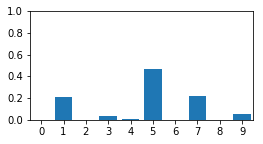

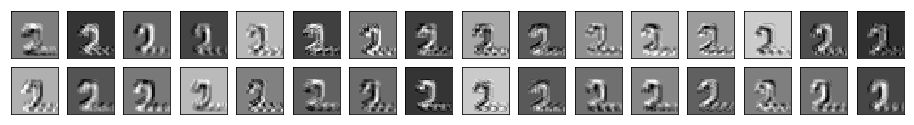

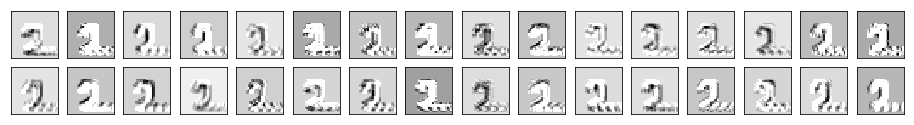

In [6]:
#test

p_val = sess.run(p, feed_dict={x:[image], keep_prob:1.0})



fig = plt.figure(figsize=(4,2))

pred = p_val[0]

print(p_val)

subplot = fig.add_subplot(1,1,1)

subplot.set_xticks(range(10))

subplot.set_xlim(-0.5,9.5)

subplot.set_ylim(0,1)

subplot.bar(range(10), pred, align='center')

plt.show()

conv1_vals, cutoff1_vals = sess.run(

    [h_conv1, h_conv1_cutoff], feed_dict={x:[image], keep_prob:1.0})



fig = plt.figure(figsize=(16,4))



for f in range(num_filters1):

    subplot = fig.add_subplot(4, 16, f+1)

    subplot.set_xticks([])

    subplot.set_yticks([])

    subplot.imshow(conv1_vals[0,:,:,f],

                   cmap=plt.cm.gray_r, interpolation='nearest') 

plt.show()

fig = plt.figure(figsize=(16,4))



for f in range(num_filters1):

    subplot = fig.add_subplot(4, 16, f+1)

    subplot.set_xticks([])

    subplot.set_yticks([])

    subplot.imshow(cutoff1_vals[0,:,:,f],

                   cmap=plt.cm.gray_r, interpolation='nearest') 

    

plt.show()




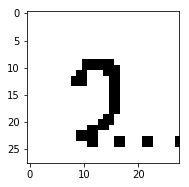

In [21]:
fig=plt.figure()

subplot1=fig.add_subplot(1,2,1)


subplot1.imshow(sess.run(tf.reshape(image, [28, 28])), cmap=plt.cm.gray_r, interpolation = 'nearest')

plt.show()